# Customer Lifetime Value

Group members:


1.   Fariz Abdussalam
2.   Brian damar



#Importing data and libraries

In [1]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 14.0 MB/s 


In [2]:
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install --upgrade gap-stat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
import numpy as np
import pandas as pd 
import scipy.stats as stats

In [5]:
import pandas as pd
from gap_statistic import OptimalK
import urllib
import json
#import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# numpy for array manipulation
import numpy as np
# pandas for dataframe manipulation
import pandas as pd
# matplotlib for data visualization
import matplotlib.pyplot as plt

#split training set and test set
from sklearn.model_selection import train_test_split
# import regression model
from sklearn.linear_model import LinearRegression
# import metrics module from scikit-learn
from sklearn import metrics

# load lifetimes plotting module
from lifetimes.plotting import *
# load lifetimes utils module
from lifetimes.utils import *
# load BetaGeoFitter model
from lifetimes import BetaGeoFitter
# load GammaGammaFitter
from lifetimes import GammaGammaFitter

# seaborn for preety data visualization
import seaborn as sns

# import datetime for date manipulation
import datetime as dt

In [7]:
customers = pd.read_csv('https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_customers_dataset.csv',lineterminator='\n')
geolocation = pd.read_csv('https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_geolocation_dataset.csv')
orders = pd.read_csv('https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_orders_dataset.csv')
order_items = pd.read_csv('https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/olist_ecommerce_data/olist_order_items_dataset.csv')

# Task 1: Create RFM Segmentation

## EDA

In [8]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [9]:
order_items_silver = order_items.groupby('order_id').agg({'price':sum,'freight_value':sum,'shipping_limit_date':max }).reset_index()


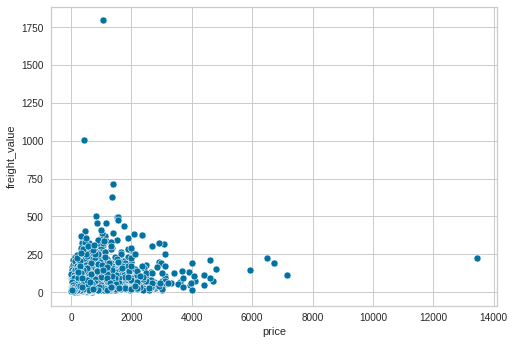

In [10]:
sns.scatterplot(x='price',y='freight_value',data=order_items_silver)


from the plot we can see there is an outlier for price and freight value. We decided to remove orders with a price over R$ 5000 and for the freight value we used logic as a value that is far away from 99% percentile.x


In [11]:
percentil_freight_value = order_items_silver['freight_value'].quantile(0.99)
order_items_silver = order_items_silver[(order_items_silver['price'] <= 5000) & (order_items_silver['freight_value'] <= percentil_freight_value)]

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [13]:
columns_timestamp = ['order_purchase_timestamp','order_approved_at',
                     'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for column in columns_timestamp:
    orders[column] = pd.to_datetime(orders[column])

In [14]:
orders['diff_delivery_days'] = (orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']).dt.days

In [15]:
print(orders['diff_delivery_days'].describe())


count    96476.000000
mean        10.876881
std         10.183854
min       -189.000000
25%          6.000000
50%         11.000000
75%         16.000000
max        146.000000
Name: diff_delivery_days, dtype: float64


As we can see, the median difference between the estimated delivery and the actual delivery is 10 days, which is a bit high. Another fact is that  there are orders who are delivered several weeks before or after estimated delivery time time. we assume these are the outliers, hence We will remove the order which delivered before estimated date and we will remove the order which difference between delivered date and estimated date is more than 75% of difference in days (16). In other words, we keep orders where the difference between delivery day and estimated delivery day is between 0 to 20 (we set 20 as our limit because the 75th percentile of orders have 17 days as difference between delivery day and estimated delivery day)

In [16]:
orders_rev1 = orders.loc[orders['diff_delivery_days'].between(0,21) ]

In [17]:
orders_rev1['diff_delivery_days'].max()

21.0

In [18]:
orders_silver = orders_rev1.merge(order_items_silver,on='order_id',how='inner')

In [19]:
orders_customers_raw = customers.merge(orders_silver, on='customer_id', how='inner')

In [20]:
orders_customers = orders_customers_raw.dropna()

In [21]:
max_date = max(orders_customers['order_purchase_timestamp']) + datetime.timedelta(days=1)

In [39]:
rfm_data_raw = orders_customers.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,
    'customer_id':'count',
    'price':'sum'
}).reset_index()
rfm_data_raw.columns =['customer_id','recency','frequency','monetary']

In [54]:

rfm_data = rfm_data_raw.drop(columns=["customer_id"])

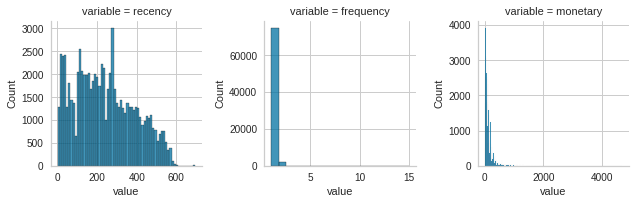

In [55]:
g = sns.FacetGrid(
    data = pd.melt(
     rfm_data[["recency", "frequency","monetary"]],
     value_vars=["recency", "frequency","monetary"]
    ),
    col = "variable",
    sharex = False,
    sharey = False
)
g.map(sns.histplot, "value");

In [53]:
rfm_data.describe()

,recency,frequency,monetary
count,69573.000000,69573.0,69573.000000
mean,239.545988,1.0,93.116694
std,149.374371,0.0,65.257836
min,1.000000,1.0,0.850000
25%,119.000000,1.0,42.000000
50%,225.000000,1.0,78.000000
75%,351.000000,1.0,129.000000
max,695.000000,1.0,305.900000


Insight we can get from these 3 plots, after dropping outliers is


1.   All customers buy only 1 time
2.   Customers recency scores are varies between 0 - 600



## RFM Segmentation using Kmeans

because most customers buy only one time, then we hypothesise there are 3 clusters. 
1. clustes 1 who only buy one time, 
2. cluster 2 who do repeat orders, but maybe there is a high risk to churn
3. cluster 3 who do repeat orders and they are our promising customers

In [56]:
def k_means_group(data, n_clusters, random_state, asc=False, log_transf=False, standard_tranf=False):
    
    data_temp = data.copy()
    if log_transf:
        data_temp = np.log(data_temp) + 1
        
    if standard_tranf:
        scaler = StandardScaler()
        scaler = scaler.fit(data_temp)
        data_temp = scaler.transform(data_temp)
        
    kmeans_sel = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data_temp)
    
    cluster_group = data.assign(cluster = kmeans_sel.labels_)
    
    mean_group = cluster_group.groupby('cluster').mean().reset_index()
    mean_group = mean_group.sort_values(by=mean_group.columns[1],ascending=asc)
    mean_group['cluster_set'] = [i for i in range(n_clusters, 0, -1) ]
    
    cluster_map = mean_group.set_index('cluster').to_dict()['cluster_set']
    
    return cluster_group['cluster'].map(cluster_map)

In [57]:
r_labels = k_means_group(rfm_data[['recency']],3,1,asc=True)
f_labels = k_means_group(rfm_data[['frequency']],3,1)
m_labels = k_means_group(rfm_data[['monetary']],3,1)

rfm_data = rfm_data.assign(R = r_labels, F = f_labels, M = m_labels)

In [58]:
rfm_data.groupby('R')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
R,,,,,,,,
1,19448.0,444.200843,62.833205,350.0,391.0,438.0,490.0,695.0
2,28621.0,254.335418,49.273938,171.0,212.0,257.0,291.0,349.0
3,28826.0,86.502706,50.240299,1.0,38.0,87.0,131.0,170.0


Insight: 


1.   Cluster 1 has low recency score
2.   Cluster 2 has moderate recency score
3.  cluster 3 has high recency score



In [59]:
rfm_data.groupby('F')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
F,,,,,,,,
1,74889.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,1858.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
3,148.0,3.391892,1.254299,3.0,3.0,3.0,3.0,15.0


As expected, most customers only buy one time

In [60]:
def get_segment(data):
    mean_fm = (data['F'] + data['M']) / 2
    
    if (data['R'] >= 2 ) and (mean_fm >= 2 ):
        return 'Potential Loyalist'
    if (data['R'] >= 2 ) and (mean_fm < 2):
        return 'Customer Needing Attention'
    if (data['R'] == 1 ) and (mean_fm >= 0 and mean_fm < 3):
        return 'At Risk'
    return str(data['R'])+"_"+str(mean_fm)

In [61]:
rfm_data['segment'] = rfm_data.apply(get_segment,axis=1)

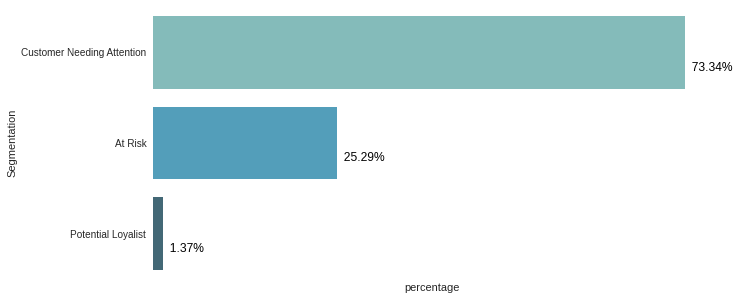

In [62]:
plt.figure(figsize=(10,5))
percentage = (rfm_data['segment'].value_counts(normalize=True)* 100).reset_index(name='percentage')
g = sns.barplot(x=percentage['percentage'],y=percentage['index'], data=percentage,palette="GnBu_d")
sns.despine(bottom = True, left = True)
for i, v in enumerate(percentage['percentage']):
    g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
g.set_ylabel('Segmentation')
g.set(xticks=[])
plt.show()

# Task 2 : predict CLV, Probability to alive, and probability to purchase

## Frequency/Recency Analysis Using the BG/NBD Model

In [63]:
orders_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79107 entries, 0 to 79116
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    79107 non-null  object        
 1   customer_unique_id             79107 non-null  object        
 2   customer_zip_code_prefix       79107 non-null  int64         
 3   customer_city                  79107 non-null  object        
 4   customer_state                 79107 non-null  object        
 5   order_id                       79107 non-null  object        
 6   order_status                   79107 non-null  object        
 7   order_purchase_timestamp       79107 non-null  datetime64[ns]
 8   order_approved_at              79107 non-null  datetime64[ns]
 9   order_delivered_carrier_date   79107 non-null  datetime64[ns]
 10  order_delivered_customer_date  79107 non-null  datetime64[ns]
 11  order_estimated

In [64]:
data = orders_customers[["customer_unique_id","order_purchase_timestamp","price"]]

In [65]:
df_rfm_lifetime = summary_data_from_transaction_data(
    data, 
    'customer_unique_id', 
    'order_purchase_timestamp', 
    monetary_value_col='price', 

)

In [66]:
df = df_rfm_lifetime.query('frequency > 0')

In [67]:
df.describe()

,frequency,recency,T,monetary_value
count,1452.000000,1452.000000,1452.000000,1452.000000
mean,1.104683,119.011019,311.675620,123.975967
std,0.517168,115.786460,139.346111,140.436767
min,1.000000,1.000000,7.000000,5.990000
25%,1.000000,24.000000,204.000000,47.572500
50%,1.000000,79.000000,323.000000,89.725000
75%,1.000000,185.250000,423.000000,149.111250
max,14.000000,633.000000,695.000000,1599.000000


In [68]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(df['frequency'], df['recency'], df['T'])

<lifetimes.BetaGeoFitter: fitted with 1452 subjects, a: 2.52, alpha: 2133.28, b: 0.30, r: 20.06>

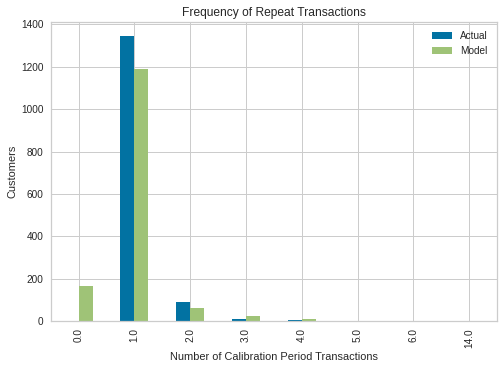

In [69]:
plot_period_transactions(bgf, max_frequency=30)

We can see that our actual data and our simulated data line up well. 
So, we can continue on with our analysis. We now partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (just like cross-validation in machine learning practice).

In [70]:
print(data["order_purchase_timestamp"].max())
print(data["order_purchase_timestamp"].min())

2018-08-29 15:00:37
2016-10-03 09:44:50


In [71]:
pd.get_option("display.max_columns")
summary_cal_holdout = calibration_and_holdout_data(
    data, 'customer_unique_id', 
    'order_purchase_timestamp', 
    calibration_period_end='2018-02-08',
    observation_period_end='2018-05-09'
)

In [72]:
bgf = BetaGeoFitter(penalizer_coef=0)

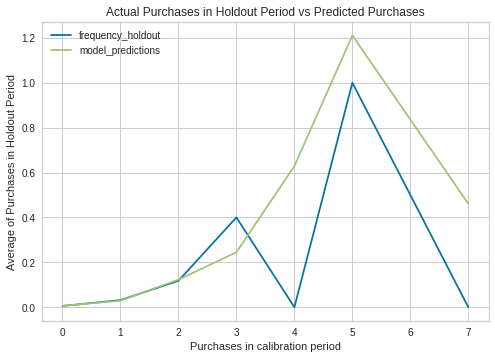

In [73]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In this plot, we separate the data into both a in-sample (calibration) and validation (holdout) period. The sample period consists the beginning to 2018–02–08; the validation period spans from 2018–02–09 to 2018–05–09. The plot groups all customers in the calibration period by their number of repeat purchases (x-axis) and then averages over their repeat purchases in the holdout period (y-axis). The orange and blue line presents the model prediction and actual result of the y-axis respectively. As we can see, our model is able to predict the customer base’s behaviour out of the sample, however the model over-estimates after 3 purchase. But our model still capture the pattern of transaction

Predict probability to alive and purchase for next 7,14,30,60 days

In [74]:
# pick period
all_t = [7,14,30,60]
#predict probability alive
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'], df['recency'], df['T'])
# predict purchases
for t in all_t:
  df['predicted_purchases_next_'+str(t)+'_days'] = bgf.conditional_expected_number_of_purchases_up_to_time(
      t, df['frequency'], df['recency'], df['T'])
  


## The Gamma-Gamma model and the independence assumption


Gamma-Gamma model is based on the assumption that the number of transactions does not depend on their monetary value. The frequency and monetary value are not correlated if the output is close to zero. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [75]:
summary = df[df['frequency']>0]

In [76]:
df.describe()

,frequency,recency,T,monetary_value,prob_alive,predicted_purchases_next_7_days,predicted_purchases_next_14_days,predicted_purchases_next_30_days,predicted_purchases_next_60_days
count,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000,1452.000000
mean,1.104683,119.011019,311.675620,123.975967,0.082200,0.002575,0.005051,0.010382,0.019355
std,0.517168,115.786460,139.346111,140.436767,0.065883,0.005739,0.011277,0.023262,0.043622
min,1.000000,1.000000,7.000000,5.990000,0.010747,0.000164,0.000326,0.000689,0.001344
25%,1.000000,24.000000,204.000000,47.572500,0.041009,0.000769,0.001519,0.003184,0.006100
50%,1.000000,79.000000,323.000000,89.725000,0.070022,0.001453,0.002870,0.005965,0.011306
75%,1.000000,185.250000,423.000000,149.111250,0.106158,0.002494,0.004921,0.010103,0.019018
max,14.000000,633.000000,695.000000,1599.000000,0.842105,0.165955,0.327807,0.683155,1.299490


In [77]:
#check assumption that there is no correlation between monetary and frequency
summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,-0.006573
frequency,-0.006573,1.000000


In [78]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(summary['frequency'],
        summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1452 subjects, p: 2.86, q: 3.06, v: 89.99>


In [79]:
#predict CLV for 12 months with discount rate 0.01 each month
df["predicted_clv"] = ggf.customer_lifetime_value( 
    bgf, #the model to use to predict the number of future transactions 
    summary['frequency'], 
    summary['recency'], 
    summary['T'], 
    summary['monetary_value'], time=12, # months 
    discount_rate=0.01,
    freq = "M")

In [80]:
df.head()

,frequency,recency,T,monetary_value,prob_alive,predicted_purchases_next_7_days,predicted_purchases_next_14_days,predicted_purchases_next_30_days,predicted_purchases_next_60_days,predicted_clv
customer_unique_id,,,,,,,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,398.0,87.90,0.073817,0.001147,0.002273,0.004771,0.009197,0.189290
00a39521eb40f7012db50455bf083460,1.0,11.0,98.0,11.55,0.064167,0.002905,0.005660,0.011463,0.020827,0.270570
011575986092c30523ecb71ff10cb473,1.0,60.0,193.0,63.90,0.068831,0.001940,0.003817,0.007888,0.014804,0.275673
011b4adcd54683b480c4d841250a987f,1.0,177.0,372.0,113.94,0.079960,0.001317,0.002609,0.005471,0.010524,0.249152
012452d40dafae4df401bced74cdb490,1.0,330.0,437.0,330.00,0.111799,0.001600,0.003173,0.006673,0.012898,0.623911


# Task 3: Refine our segmentation by adding CLV

#find number of cluster 

In [81]:
df.corr()

,frequency,recency,T,monetary_value,prob_alive,predicted_purchases_next_7_days,predicted_purchases_next_14_days,predicted_purchases_next_30_days,predicted_purchases_next_60_days,predicted_clv
frequency,1.000000,0.185738,0.079072,-0.006573,0.624193,0.796545,0.800344,0.807646,0.817772,0.616170
recency,0.185738,1.000000,0.479540,-0.016449,0.582047,0.134889,0.138581,0.146049,0.157391,0.120942
T,0.079072,0.479540,1.000000,0.000639,-0.064742,-0.203330,-0.197933,-0.186943,-0.170137,-0.241698
monetary_value,-0.006573,-0.016449,0.000639,1.000000,-0.022314,-0.017729,-0.017769,-0.017825,-0.017856,0.283751
prob_alive,0.624193,0.582047,-0.064742,-0.022314,1.000000,0.737384,0.738307,0.739877,0.741597,0.686972
predicted_purchases_next_7_days,0.796545,0.134889,-0.203330,-0.017729,0.737384,1.000000,0.999932,0.999394,0.997633,0.763383
predicted_purchases_next_14_days,0.800344,0.138581,-0.197933,-0.017769,0.738307,0.999932,1.000000,0.999732,0.998366,0.762186
predicted_purchases_next_30_days,0.807646,0.146049,-0.186943,-0.017825,0.739877,0.999394,0.999732,1.000000,0.999421,0.759502
predicted_purchases_next_60_days,0.817772,0.157391,-0.170137,-0.017856,0.741597,0.997633,0.998366,0.999421,1.000000,0.754812
predicted_clv,0.616170,0.120942,-0.241698,0.283751,0.686972,0.763383,0.762186,0.759502,0.754812,1.000000


based on the correlation table, we should drop our predicted_purchase variables because they are highly correlated with frequency

In [82]:
import re
predicted_purchase = [ x for x in df.columns if re.search("predicted_purchases_",x)]

In [83]:
data_for_model = df.drop(columns=predicted_purchase+["T"])

## using Gap statistic

In [84]:
scaler_obj = StandardScaler()
scaled_data = scaler_obj.fit_transform(data_for_model.to_numpy())
data_for_kmeans = pd.DataFrame(scaled_data, columns = data_for_model.columns )

In [85]:
data_for_kmeans.head()

,frequency,recency,monetary_value,prob_alive,predicted_clv
0,-0.202486,0.449162,-0.256973,-0.127273,-0.316356
1,-0.202486,-0.933168,-0.800821,-0.273804,-0.230435
2,-0.202486,-0.509829,-0.427927,-0.202978,-0.225041
3,-0.202486,0.501000,-0.071487,-0.034013,-0.253076
4,-0.202486,1.822853,1.467529,0.449427,0.143083


In [86]:
optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')

In [87]:
n_clusters = optimalK(data_for_kmeans, cluster_array=np.arange(1, 6))
print('Optimal clusters using Gap Statistic: ', n_clusters)

Optimal clusters using Gap Statistic:  1


## using elbow method

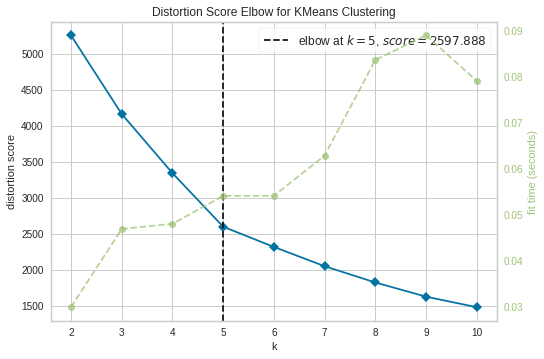

In [88]:
model = KElbowVisualizer(KMeans(random_state=1000), k=10)
model.fit(data_for_kmeans)
model.show()

Optimal cluster using Elbow method : *5*

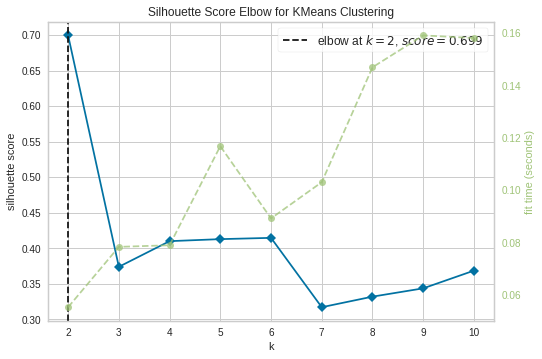

In [89]:
model = KElbowVisualizer(KMeans(random_state=1000), k=10, metric = "silhouette")
model.fit(data_for_kmeans)
model.show()

Optimal cluster using Silhoutte method : *2*

Conclusions: because each method gave as different answers, where 
 

1.   Gap statistic : 1 clusters
2.   Elbow method : 5 clusters
3.   Silhoutte : 2 clusters

We decide to choose 2 as our number of cluster because most of our customers only but 1 time, so basically there are two customers segment, those who do repeat order, and those who dont.

#Kmeans Clustering with k=2

In [90]:
kmeans_model = KMeans(
    n_clusters = 2,
    random_state=1000
)

kmeans_model.fit(data_for_kmeans)

KMeans(n_clusters=2, random_state=1000)

In [91]:
data_for_model["cluster"] = kmeans_model.labels_

total users per segment





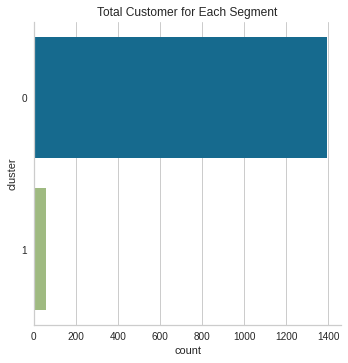

In [92]:
sns.catplot(
    y = "cluster", 
    data = data_for_model, 
    kind = "count", 
    height = 5
).ax.set_title("Total Customer for Each Segment");

As explained above, cluster 0 must be the group of customers who mostly never making a second purchase

**Recency Days Distribution of Each Segment**

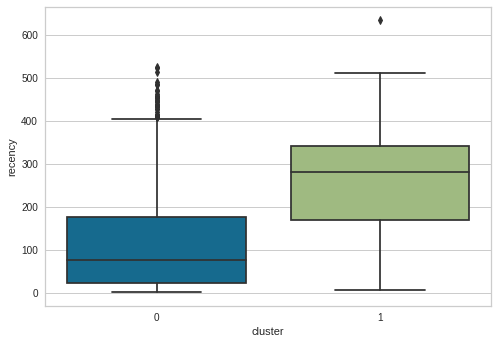

In [93]:
sns.boxplot(x = 'cluster', y = 'recency', data = data_for_model)

our cluster are divided into two, those who recently purchase and those who do not make purchase for a long time

**Transaction Frequency Distribution of Each Segment**

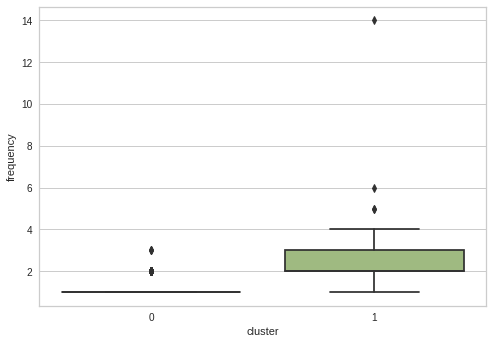

In [94]:
sns.boxplot(x = 'cluster', y = 'frequency', data = data_for_model)

As mentioned above, cluster 0 must be the group of customers who mostly never making a second purchase



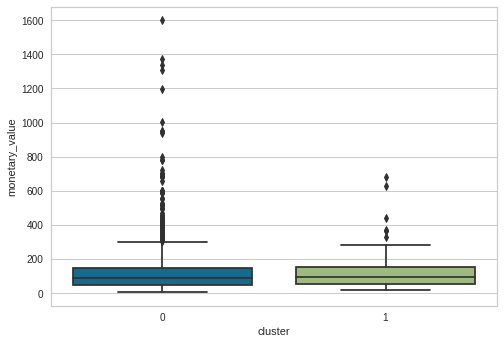

In [95]:
sns.boxplot(x = 'cluster', y = 'monetary_value', data = data_for_model)

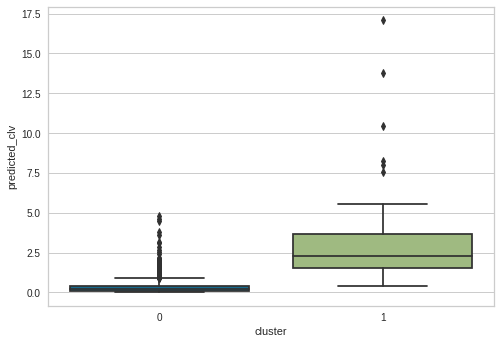

In [96]:
sns.boxplot(x = 'cluster', y = 'predicted_clv', data = data_for_model)

As expected, for those who mostly never making a second purchase have a low customer value


Based on the distribution of GMV, Recency, and Frequency, hereby the description of each cluster:


1.   Cluster 0 - Low Customers value, most customers in this cluster are first time buyer and never return to purchase again. 
2.   Cluster 1 - Promosing Customers, customers who repeat orders and have a higher CLV than cluster 0. 

